# Incremental Learning

Incremental learning is a machine learning paradigm where the learning process takes place whenever new data is added with the time and to trained for whole data that means old data + new data which will cause too much time and resource. Instead by some adjustments in model we can only train for new data and  the overall Performance is nearly same. <br>

To Demonstrate the Algorithm, the task Used **Irrelevant classification of social media post**


<!-- <div>
<img src="https://ibb.co/jD0p2sD" height="200" width="500">
</div> -->
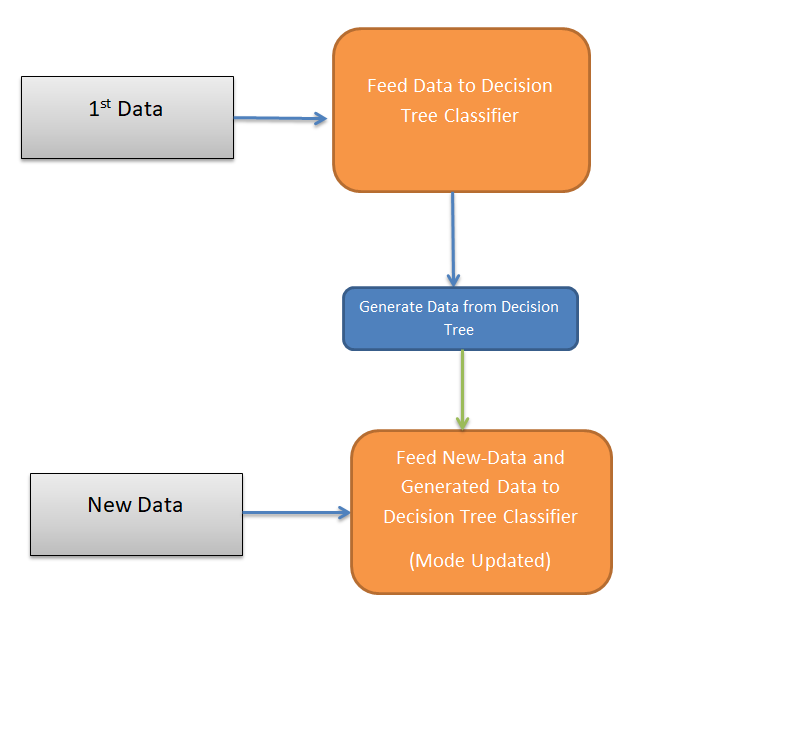
##### If Again new data comes , Repeat the Second part of above image for updating model parameter



## Decision Tree Data Generating
* Get the Skeleton of Decision Tree
* Store all the nodes,leaves and their Thresholds.
* Get all possible combination of data using node and leaves, such that generated data depicts the strucutre of Decision Tree
* Use AUC(Area Under Cover), to verify the quality of data.
<br>

<div>
<img src="https://miro.medium.com/max/1174/1*7wRAwQjvOGXNUx753F_-Vg.png" height="200" width="500">
</div>
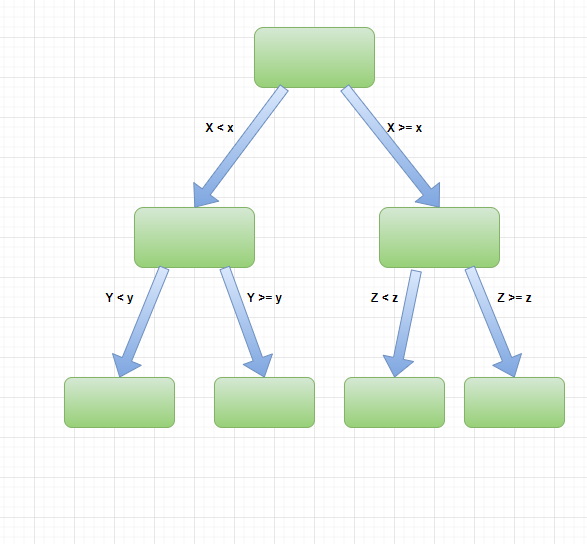

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

# Import dataset and divide in 3 group
* all the data is preprocesed and Normalized, focused only to show the Incremental Learning

In [2]:
train=pd.read_csv('../input/preprocessed-disaster-dataset/train.csv') 
test=pd.read_csv('../input/preprocessed-disaster-dataset/test.csv')
features=train.columns[0:-1]

Score=[]

## Create 3 groups for simulation as if they are generated after period of time


In [3]:
from sklearn.model_selection import KFold
incremental_data_X=[]

#split seprately the class 0 and 1 and combined then+
kf_0 = KFold(n_splits=3,random_state=42, shuffle=True) 
kf_1 = KFold(n_splits=3,random_state=42, shuffle=True)
irrelevant=train[train['target']==0].reset_index(drop=True)
relevant=train[train['target']==1].reset_index(drop=True)

for (_, val_index1),(_,val_index2) in zip(kf_0.split(irrelevant),kf_1.split(relevant)):
    incremental_data_X.append(pd.concat([irrelevant.loc[val_index1],relevant.loc[val_index2]],axis=0)) 

## get all the tree detail
* left and right child
* threshold
* depth
* leave node value

In [4]:

def get_tree_detail(clf,index_features):
    #get the tree details
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left #left child node
    children_right = clf.tree_.children_right #right child node
    feature = clf.tree_.feature #feature index
    threshold = clf.tree_.threshold #threshold
    node_value=clf.tree_.value #node value
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]
    Dict={}
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True
    j=0
    for i in range(n_nodes):
        if is_leaves[i]:
            Dict[i]={'name':None,'depth':node_depth[i],'left':None,'right':None,'thresh':None,'value':node_value[i],'leaves_node':True}
        else: 
            Dict[i]={'name':features[index_features[i]],'depth':node_depth[i],'left':children_left[i],'right':children_right[i],'thresh':float(threshold[i]),'value':node_value[i],'leaves_node':False}
            j+=1
    return Dict

def get(Dict,i):
    temp=Dict[i]
    if(temp['left'] is not None):
        Id=temp['left']
        Dict[i]['left']=get(Dict,Id)
            
    if(temp['right'] is not None):
        Id=temp['right']
        Dict[i]['right']=get(Dict,Id)
        
    return Dict[i]

      

## Data generation

### Sample Diagram for Explaination

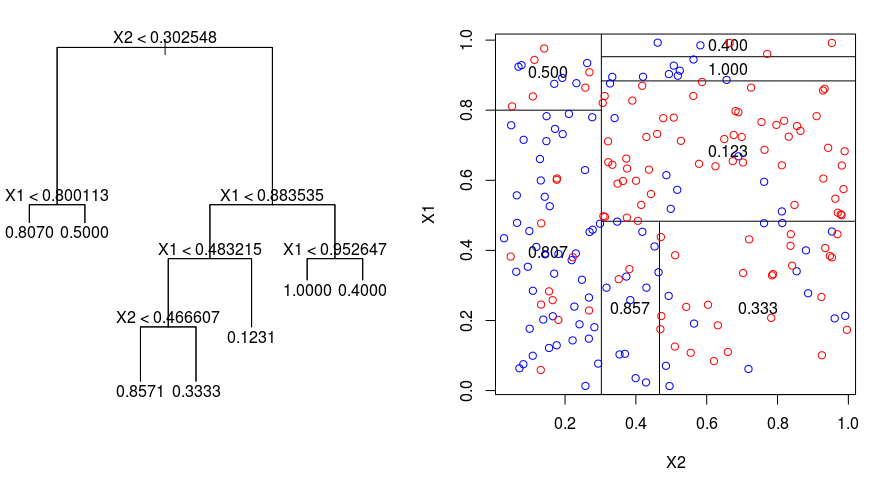

* randomly generate data points on every region or box (above image)
* store the value of generated data and corresponding class value

In [5]:
from copy import  deepcopy

generated_data=pd.DataFrame()
n=100
def generator(Dict,feature_detail,Index):
    #print()
    if(Dict['name'] is None):#leave node
        if('target' not in generated_data.columns):
            generated_data['target']=np.NaN
        generated_data['target'].loc[Index]=np.argmax(Dict['value'])#get dominat class
    else:
        detail=feature_detail[Dict['name']]
        if(detail['dtype'] is 'category'):
            cat=True
            #generate data in the given category
            category=detail['values']
            #n should be size of data frame  see for sample weight in order to replicate real data
        else:
            cat=False
            #continous type
            Min=detail['min'] #store the min and max for non categorical
            Max=detail['max']

        if(Index is None):
            if(cat):
                values=np.random.choice(category,n) #get random sample form the uniform distrubution
            else:
                values=np.random.uniform(Min,Max,n) # get the random value 
            generated_data[Dict['name']]=values
            Index=generated_data.index

        else:
            if(cat):

                values=np.random.choice(category,len(Index))
            else:
                #generate data between min and max
                #Futher: Use some of the distrubution
                values=np.random.uniform(Min,Max,len(Index))


            try:
                generated_data[Dict['name']].loc[Index]=values

            except:
                generated_data[Dict['name']]=np.NaN
                generated_data[Dict['name']].loc[Index]=values
        
        #go to left
        temp=generated_data.loc[Index].copy()

        left_index=temp.loc[temp[Dict['name']]<=Dict['thresh']].index
        left_feature_detail=deepcopy(feature_detail)
        if(cat):
            category=np.array(category)
            left_feature_detail[Dict['name']]['values']=category[category<=Dict['thresh']]
        else:
            left_feature_detail[Dict['name']]['max']=Dict['thresh']

        generator(Dict['left'],left_feature_detail,left_index)

        #go to right
        right_index=temp.loc[temp[Dict['name']]>Dict['thresh']].index
        right_feature_detail=deepcopy(feature_detail)

        if(cat):
            category=np.array(category)
            right_feature_detail[Dict['name']]['values']=category[category>Dict['thresh']]
        else:
            right_feature_detail[Dict['name']]['min']=Dict['thresh']+0.02


        generator(Dict['right'],right_feature_detail,right_index)


#finally see for duplicates or look what to do
#suppose parent node is intialized and passed to function

In [6]:
#get feature detail.
#along some statistical details.

rows=train.shape[0]
feature_detail={}
for col in features:
    unq_elem=np.unique(train[col])
    tmp=len(unq_elem)
    if(tmp<rows//2 and 'int' in str(train[col].dtype)):
        #categorical
        feature_detail[col]={'dtype':'category','values':unq_elem}
    else:
        #continous
        feature_detail[col]={'dtype':train[col].dtype,'max':train[col].max(),'min':train[col].min(),'mean':train[col].mean()}

# Phase I

In [7]:
def get_misclassify_data(pred,actual,X):
    index=np.where(actual!=pred)[0]
    data=X.iloc[index].copy()
    data['target']=actual[index]
    return data

In [8]:
clf = DecisionTreeClassifier(max_depth=6, random_state=0)
X=incremental_data_X[0].copy().reset_index(drop=True)
y=X['target']
X.drop(columns=['target'],inplace=True)

clf.fit(X,y)
data_missclassified=get_misclassify_data(clf.predict(X),y,X)
#fimnd
b_AUC=round( roc_auc_score(y, clf.predict(X)),3)
print("AUC of Batch 1 : ",b_AUC)
train_AUC=round( roc_auc_score(train['target'].values, clf.predict(train.iloc[:,0:-1])),3)
print("AUC of train_data : ",train_AUC)
test_AUC=round( roc_auc_score(test['target'], clf.predict(test.iloc[:,0:-1])),3)
print("AUC of test_data : ",test_AUC)

Score.append(['batch-1',b_AUC,train_AUC,test_AUC])


#clf.feature_importances_ ##note this

AUC of Batch 1 :  0.862
AUC of train_data :  0.84
AUC of test_data :  0.812


In [9]:
precision_recall_fscore_support(train['target'].values, clf.predict(train.iloc[:,0:-1]),average='micro')

(0.8553737284387439, 0.8553737284387439, 0.8553737284387439, None)

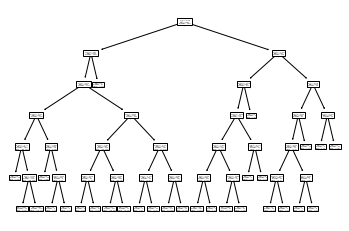

In [10]:
from sklearn import tree
text=tree.plot_tree(clf)
index_features=[]
for i in range(len(text)):
    temp=text[i].get_text().split('<=')[0][2:-2]
    if(temp.isdigit()):
        index_features.append(int(temp))
    else:
        index_features.append(None)

In [11]:
#get the tree detail and store in Dictionary
Dict=get_tree_detail(clf,index_features)
_==get(Dict,0)
Dict=Dict[0]

# Generated Data,
* set n=100 to get 100 data points

In [12]:
from sklearn.metrics import confusion_matrix
n=100 # get 100 sample form the classifier
generated_data=pd.DataFrame()
generator(Dict,feature_detail,Index=None)

colum_drop=generated_data.columns[np.where(n==generated_data.isna().sum().values)[0]]
generated_data.drop(columns=colum_drop,inplace=True)

for col in features:
    if(col not in generated_data.columns ):
        if(feature_detail[col]['dtype'] is 'category'):
            category=feature_detail[col]['values']
            generated_data[col]=np.random.choice(category,n)
        else:
            Min,Max=feature_detail[col]['min'],feature_detail[col]['max']
            generated_data[col]=np.random.uniform(Min,Max,n)

target=generated_data['target']
generated_data=generated_data[features]
generated_data.fillna(value=generated_data.mean(),inplace=True)
print('AUC',clf.score(generated_data,target)) 
generated_data=generated_data.fillna(value=generated_data.mean())

print('Confusion Matrix')
confusion_matrix(target, clf.predict(generated_data))

AUC 1.0
Confusion Matrix


array([[53,  0],
       [ 0, 47]])

**AUC-1 means generated data depicts the decision tree and able to preserve the skeleton of decision tree.**

In [13]:
generated_data['target']=target
generated_data

,message_length,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9,...,91,92,93,94,95,96,97,98,99,target
0,2.441813,-0.188064,-0.272992,-1.197602,-1.041271,-0.881773,-0.253311,-0.950472,0.690429,1.553011,...,-0.571381,0.954965,-0.222845,1.554189,-1.185244,-0.059088,1.142909,0.252433,0.851040,1.0
1,3.689812,0.146489,-0.819956,-0.308189,-1.669744,0.619107,-0.365163,-0.123269,-1.237915,1.423189,...,-0.894784,0.580390,-0.213952,1.554189,0.464921,0.698700,1.421293,0.268669,1.164339,1.0
2,3.392702,-1.050804,0.242542,0.380390,-1.558772,0.348425,-0.722350,-0.123269,-0.350665,-0.461114,...,-1.682132,0.134077,-0.894239,1.554189,0.523897,0.385498,1.016048,-1.085323,1.160480,0.0
3,1.001602,1.302741,1.312250,-0.940628,-0.083603,0.922556,-0.593381,-0.123269,0.235261,-0.573226,...,-0.668681,1.488633,0.929100,1.554189,1.287955,-0.450511,-0.908735,-0.185154,-0.593097,1.0
4,1.897079,0.428330,0.150250,-0.234981,0.010791,-0.668847,-0.508146,0.266941,0.010292,0.163225,...,-1.604771,-0.328762,-0.340766,1.554189,0.651122,0.797125,-0.873238,0.225133,-0.475949,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.392576,0.588778,1.296975,0.277718,0.407491,0.809922,-0.089909,-0.123269,-1.279630,0.105531,...,-1.747457,0.307686,0.450028,1.554189,-0.694742,-0.567475,-0.057325,0.868670,-0.468594,0.0
96,2.377919,0.064858,0.194030,0.883032,-0.460338,1.332576,0.004599,-0.123269,-0.145154,0.669069,...,-0.664784,1.960738,0.297490,1.554189,-0.142623,0.014189,0.370585,1.017008,0.292873,1.0
97,0.722466,0.386322,1.533187,0.097862,-1.452436,1.110563,0.191954,-0.123269,-0.392845,0.040003,...,-0.756743,0.802142,-0.743318,1.554189,-1.253171,-1.085398,0.493435,0.989287,-0.897395,0.0
98,1.292273,0.867631,-0.082662,0.727160,0.017811,-0.041535,-0.523640,1.002857,-1.386305,-0.624175,...,-0.663295,0.427106,0.517704,1.554189,-0.148046,-0.256047,-1.119191,0.532884,0.593144,0.0


<!-- ### Work to deal with NaN values -->

# Phase II

* After Data Generation 
* Get the New data
* combine both data and update the model

In [14]:
clf = DecisionTreeClassifier(max_depth=6, random_state=0)
X=incremental_data_X[1].copy()
y=X['target'].values
X.drop(columns=['target'],inplace=True)

y_gen=generated_data['target'].values
y_mis_clf=data_missclassified.iloc[:,-1]
generated_data.drop(columns=['target'],inplace=True)
y=np.hstack([y,y_gen,y_mis_clf])
updated_data=pd.concat([X,generated_data,data_missclassified.iloc[:,0:-1]],axis=0).reset_index(drop=True)

clf.fit(updated_data,y)
data_missclassified=get_misclassify_data(clf.predict(X),y,X)

b_AUC=round( roc_auc_score(y, clf.predict(updated_data)),3)
print("AUC of Batch 2 : ",b_AUC)
train_AUC=round( roc_auc_score(train['target'].values, clf.predict(train.iloc[:,0:-1])),3)
print("AUC of train_data : ",train_AUC)
test_AUC=round( roc_auc_score(test['target'], clf.predict(test.iloc[:,0:-1])),3)
print("AUC of test_data : ",test_AUC)

Score.append(['batch-2',b_AUC,train_AUC,test_AUC])

AUC of Batch 2 :  0.831
AUC of train_data :  0.835
AUC of test_data :  0.822


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [15]:
precision_recall_fscore_support(train['target'].values, clf.predict(train.iloc[:,0:-1]),average='micro')

(0.8555211558307534, 0.8555211558307534, 0.8555211558307534, None)

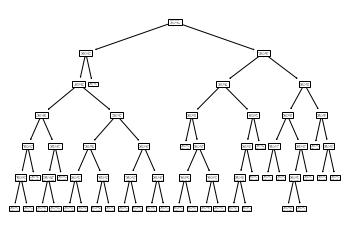

In [16]:
from sklearn import tree
text=tree.plot_tree(clf)
index_features=[]
for i in range(len(text)):
    temp=text[i].get_text().split('<=')[0][2:-2]
    if(temp.isdigit()):
        index_features.append(int(temp))
    else:
        index_features.append(None)

In [17]:
Dict=get_tree_detail(clf,index_features)
_==get(Dict,0)
Dict=Dict[0]

In [18]:
from sklearn.metrics import confusion_matrix
n=100
generated_data=pd.DataFrame()
generator(Dict,feature_detail,Index=None)

colum_drop=generated_data.columns[np.where(n==generated_data.isna().sum().values)[0]]
generated_data.drop(columns=colum_drop,inplace=True)

for col in features:
    if(col not in generated_data.columns ):
        if(feature_detail[col]['dtype'] is 'category'):
            category=feature_detail[col]['values']
            generated_data[col]=np.random.choice(category,n)
        else:
            Min,Max=feature_detail[col]['min'],feature_detail[col]['max']
            generated_data[col]=np.random.uniform(Min,Max,n)

target=generated_data['target']
generated_data=generated_data[features]
generated_data.fillna(value=generated_data.mean(),inplace=True)
print('AUC',clf.score(generated_data,target)) 
generated_data=generated_data.fillna(value=generated_data.mean())

confusion_matrix(target, clf.predict(generated_data))

AUC 1.0


array([[54,  0],
       [ 0, 46]])

## PHASE III

In [19]:
generated_data['target']=target

clf = DecisionTreeClassifier(max_depth=6, random_state=0)
X=incremental_data_X[2].copy()
y=X['target'].values
X.drop(columns=['target'],inplace=True)

y_gen=generated_data['target'].values
y_mis_clf=data_missclassified.iloc[:,-1]
generated_data.drop(columns=['target'],inplace=True)
y=np.hstack([y,y_gen,y_mis_clf])
updated_data=pd.concat([X,generated_data,data_missclassified.iloc[:,0:-1]],axis=0).reset_index(drop=True)
clf.fit(updated_data,y)
clf.score(updated_data,y)



b_AUC=round( roc_auc_score(y, clf.predict(updated_data)),3)
print("AUC of Batch 3 : ",b_AUC)
train_AUC=round( roc_auc_score(train['target'].values, clf.predict(train.iloc[:,0:-1])),3)
print("AUC of train_data : ",train_AUC)
test_AUC=round( roc_auc_score(test['target'], clf.predict(test.iloc[:,0:-1])),3)
print("AUC of test_data : ",test_AUC)

Score.append(['batch-3',b_AUC,train_AUC,test_AUC])

AUC of Batch 3 :  0.861
AUC of train_data :  0.838
AUC of test_data :  0.82


In [20]:
precision_recall_fscore_support(train['target'].values, clf.predict(train.iloc[:,0:-1]),average='micro')

(0.8596491228070176, 0.8596491228070176, 0.8596491228070176, None)

# AUC for whole dataset

In [21]:
y_train=train['target'].values
X_train=train.drop(columns=['target']).copy()
#test
y_test=test['target'].values
X_test=test.drop(columns=['target']).copy()

clf = DecisionTreeClassifier(max_depth=6,random_state=0)
clf.fit(X_train,y_train)
print("AUC of Train:",roc_auc_score(y_train,clf.predict(X_train)))
print("AUC of Test:",roc_auc_score(y_test,clf.predict(X_test)))

AUC of Train: 0.8216051477181843
AUC of Test: 0.8047244601425708


In [22]:
Score=pd.DataFrame(Score,columns=['batch_no','Batch_AUC','train_AUC','test_AUC'])
Score

,batch_no,Batch_AUC,train_AUC,test_AUC
0,batch-1,0.862,0.840,0.812
1,batch-2,0.831,0.835,0.822
2,batch-3,0.861,0.838,0.820


* The training AUC is improving afer every batch which mean classifier is updating it's knowledge on train-data
* The training AUC in Batch_3 is 0.819 and when the entire data is trained AUC of training data  is 0.82,
* For the test_data AUC in Batch_3 is 0.806 annd for entire_data AUC is 0.804
  AUC are nearly same. 

**Most of research Paper focused only classification** <br>
**But this method can be applicable for both regression and classification Problems**